# 使用 tensorflow

从前例可以看出训练神经网络实际上是在两个层次上进行.

低级别层次上训练神经网络实际上是对张量的各种操作,如果用 tensorflow 的 api 说明

- 张量,包括存储网络状态的特殊张量.
- 张量操作,像是张量的加减 relu matmul
- 反向传播(backpropagation),一种链式计算梯度的方法.(tensorflow 中使用 GradientTape 类处理)

高层次上以 keras 的 api 说明

- layers,许多的层组合成一个神经网络模型 model
- 损失函数,定义了训练中的反馈信号.
- 优化器,定义了训练中的参数更新方法,如何进行学习.
- 指标,用来评估模型,例如模型的准确度等.
- 循环训练,执行小批量的随机梯度下降.


## 张量变量


In [94]:
import tensorflow as tf
x = tf.ones(shape=(2,1))
print(x)
x = tf.zeros(shape=(2,1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


初始化 shape(2,1) 的张量,全1 或 全0


In [95]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[ 0.35340306]
 [-0.85525894]
 [-0.47521758]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[0.33027422]
 [0.08277977]
 [0.21255636]], shape=(3, 1), dtype=float32)


随机填充值

- `tf.random.normal(shape=(3, 1), mean=0., stddev=1.)` 是从平均数0和标准差1中产生随机数.等同于 `np.random.normal(size=(3, 1), loc=0.,.scale=1.)`
- `tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)` 是从0到1的均匀分布中产生随机数.等同于 `np.random.uniform(size=(3, 1), low=0., high=1.)`


In [96]:
import numpy as np
x = np.ones(shape=(2, 2))
x[0, 0] = 0.

In [97]:
x = tf.ones(shape=(2, 2))
try:
    x[0, 0] = 0.
except Exception as e:
    print(e)

'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment


**tensorflow 创建的数组是不可变的**,而 numpy 创建的数组是可变的.

tensorflow 中创建可以修改的张量是靠 tf.Variable 类,使用 tf.Variable 需要提供 initial_value (张量初始值).


In [98]:
v = tf.Variable(initial_value=tf.random.normal(shape=[3, 1], mean=0, stddev=1))
v

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.55020344],
       [ 1.2159227 ],
       [-1.355476  ]], dtype=float32)>

创建一个 tf.Variable


In [99]:
v.assign(tf.ones((3, 1)))
print(v)
v[0, 0].assign(3.)
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>


修改 tf.Variable 需要通过 assign 方法.

修改子集也是通过 assign 方法.


In [100]:
v.assign_add(tf.ones((3,1)))
print(v)

v.assign_sub(tf.ones((3,1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>


assign_add 相当于 +=

assign_sub 相当于 -=


## 张量运算


In [101]:
a = tf.ones((2, 2))
b = tf.square(a)
print(b)
c = tf.sqrt(a)
print(c)
d = b + c
print(d)
e = tf.matmul(a, b)
print(e)
e *= d
print(e)

tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[2. 2.]
 [2. 2.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[2. 2.]
 [2. 2.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[4. 4.]
 [4. 4.]], shape=(2, 2), dtype=float32)


张量运算

- tf.square 平方
- tf.sqrt 平方根
- `+` 张量相加
- `tf.matmul` 张量乘法
- `*` 张量逐元素相乘


## 再探 GradientTape

从上面的张量运算来看,tensorflow 做了和 numpy 非常相似的工作.但是在 tensorflow 有一条是 numpy 做不到的,tensorflow 可以方便计算任何可微表达式的梯度.只要借助 GradientTape api.


In [102]:
input_var = tf.Variable(initial_value=3.)

with tf.GradientTape() as tape:
    result = tf.square(input_var)
gradient = tape.gradient(result, input_var)

print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


最常见计算梯度的形式 `gradients = tape.gradient(loss, weights)`

第二章,我们看到过 GradientTape 的输入可以是单一输入或者输入列表.可以输入常量或者更高维的张量.

到现在为止我们看到输入 tape.gradient() 都是由 tensorflow 生成的变量.但是实际上 tape.gradient() 可以接收任意的张量输入.但是默认情况下只有张量是可训练张量(trainable variables)时才会被跟踪??,对于冻结张量(常量)需要手动通过 `tape.watch()` 设置跟踪.(??有点云里雾里??)


In [103]:
input_const = tf.constant(3.)

with tf.GradientTape() as tape:
    tape.watch(input_const)
    result = tf.square(input_const)

gradient = tape.gradient(result, input_const)

计算常量张量的梯度需要 `tape.watch` 设置跟踪.

计算梯度是非常消耗资源的事情,不可能预先跟踪所有张量.为了避免资源浪费,tensorflow 默认只监视可训练的张量(trainable variables),因为通常需要计算梯度的就是这些张量.

除了计算梯度以外,我们还可以计算梯度的梯度,物理学类比的化是计算速度,再计算加速度.


In [104]:
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position = 4.9 * time**2 # ** 是乘方
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)
print(position)
print(speed)
print(acceleration)

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(9.8, shape=(), dtype=float32)


时间和位置: $p = 4.9 * time^2$

时间和速度: $s = 4.9 * 2 *time$

时间和加速度: $a = 4.9 *2$


## 端到端的 tensorflow 的线性分类器


In [105]:
num_samples_per_classs = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0,3],cov=[[1,0.5],[0.5,1]],size=num_samples_per_classs)
positive_samples = np.random.multivariate_normal(
    mean=[3,0],cov=[[1,0.5],[0.5,1]],size=num_samples_per_classs)

negative_samples 与 positive_samples 都是生成 1000 个点云

- mean 决定了点云的位置
- cov 协方差矩阵决定了点云的形状,这里是从左下到右上.


In [106]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

把 negative_samples 与 positive_samples 组合成 input.


In [107]:
targets = np.vstack((np.zeros((num_samples_per_classs, 1), dtype="float32"),
                     np.ones((num_samples_per_classs, 1), dtype="float32")))


生成标签,一维数组,2000个,前1000是0,后1000是1.

对应输入的 1000 个是类 0, 后面 1000 个的是类 1.


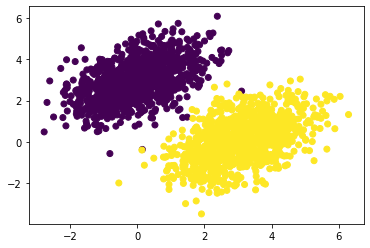

In [108]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()


将 inputs 可视化之后的样子.

接下来我们正式开始创建分类器.实际上这比第二章的例子简单多了.


In [109]:
input_dim = 2 # 输入数据阶数
output_dim = 1 # 输出数据阶数

W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))


输入是平面 2d 坐标数据

输出是一个分数,靠近 0 即类 0, 靠近 1 即类 1.


In [110]:
def model(inputs):
    return tf.matmul(inputs, W) + b # prediction = W * P + b

因为输入是 (x,y) 坐标,所以张量 W 实际上是两个标量. W = [w1,w2].同时 b 是一个标量.

预测值 `prediction = W * P + b = [w1,w2] * [x,y]] + b =w1*x+w2*y+b`.相当于只有一层神经网络.


In [111]:
def square_loss(targets, predictions):
    per_sample_loss = tf.square(
        targets - predictions)  #per_sample_loss =  (targets - predictions)^2
    return tf.reduce_mean(per_sample_loss)  # per_sample_loss 平均值


per_sample_loss 形状与 targets 相同,每个元素是一个样本的损失值.

最终 square_loss 返回是 per_sample_loss 的平均值


In [112]:
learning_rate = 0.1  # 学习率


def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)  #预测值
        loss = square_loss(targets, predictions)  #计算损失
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])  #计算梯度
    W.assign_sub(
        grad_loss_wrt_W *
        learning_rate)  #更新 W 值 W = W + grad_loss_wrt_W * learning_rate
    b.assign_sub(
        grad_loss_wrt_b *
        learning_rate)  #更新 b 值 b = b + grad_loss_wrt_b * learning_rate
    return loss

与第二章的例子不同,这里进行的是直接对整个传入的训练集训练,计算梯度更新权重.相比第二章例子每次取一部分训练集,这样训练的时间要长的多,但是我们计算反向传播和梯度时是针对全部传入样本.每次更新权重会更加准确.

在这样的前提下,学习率要比小批量训练更大.


In [113]:
for step in range(40):
    loss = training_step(inputs,targets)
    print(f"Loss at step {step}:{loss}")

Loss at step 0:0.18655896186828613
Loss at step 1:0.0974356085062027
Loss at step 2:0.08357813209295273
Loss at step 3:0.07769067585468292
Loss at step 4:0.07321707159280777
Loss at step 5:0.06924176961183548
Loss at step 6:0.06561518460512161
Loss at step 7:0.062293581664562225
Loss at step 8:0.05924953520298004
Loss at step 9:0.05645960569381714
Loss at step 10:0.05390254408121109
Loss at step 11:0.05155892297625542
Loss at step 12:0.04941090568900108
Loss at step 13:0.04744217172265053
Loss at step 14:0.045637767761945724
Loss at step 15:0.043983977288007736
Loss at step 16:0.042468223720788956
Loss at step 17:0.041078973561525345
Loss at step 18:0.03980568051338196
Loss at step 19:0.03863866627216339
Loss at step 20:0.037569060921669006
Loss at step 21:0.03658873215317726
Loss at step 22:0.035690225660800934
Loss at step 23:0.03486671671271324
Loss at step 24:0.03411194682121277
Loss at step 25:0.03342016786336899
Loss at step 26:0.03278612717986107
Loss at step 27:0.03220501169562

训练 40 轮,基本上错误率在 0.028 了.


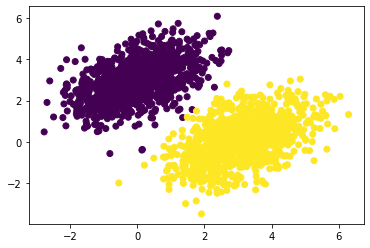

In [114]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

输出是二分类,临界点是 0.5 绘图.


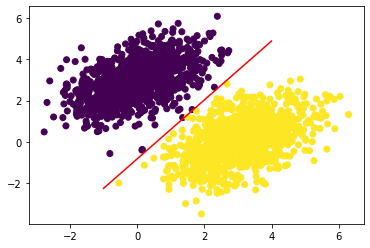

In [115]:
x = np.linspace(-1, 4, 100)
y = -W[0] / W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")  # 红线
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)


实际上直接把图画出来,类 0 和类 1 几乎就在斜率是 0.5 的直线上下.

让我想起了 svm...
